# Loading data and defining functions

In [ ]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

import jax
import jax.numpy as jnp
import seaborn as sns

import pylab as plt
import imageio
import os
import numpy as np
import time

# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from skimage import exposure
import pandas as pd

from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score,confusion_matrix, f1_score

In [ ]:
from jax.lib import xla_bridge
# Check if ultilising GPU
print(xla_bridge.get_backend().platform)

# If on CPU do the following:
# pip install --upgrade "jax[cuda]"
# change runtime to GPU 

gpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_csv  = "/content/drive/MyDrive/DSA4212/Dataset/celeba.csv"
# path = "/Users/alex/Dataset/DSA4212_dataset/celeba.csv"

attribute = pd.read_csv(path_csv)

In [ ]:
path = "/content/drive/MyDrive/DSA4212/Dataset/img_celeba_small/"
# path = "/Users/alex/Dataset/DSA4212_dataset/img_celeba_small/"

all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

# keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


# EDA

In [ ]:
data = []

for k in range(20000):
    is_male = attribute["Male"][k]
    if is_male == 1:
        data.append("Male")
    else:
        data.append("Female")

labels = pd.DataFrame(data, columns = ["Sex"])

### Distribution of Data

In [ ]:
training_labels = labels[:15000]
testing_labels = labels[15000:20000]

[Text(0.5, 1.0, 'Distribution of Training Data')]

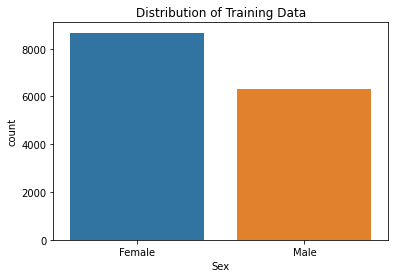

In [ ]:
sns.countplot(x="Sex", data = training_labels).set(title = "Distribution of Training Data")

[Text(0.5, 1.0, 'Distribution of Testing Data')]

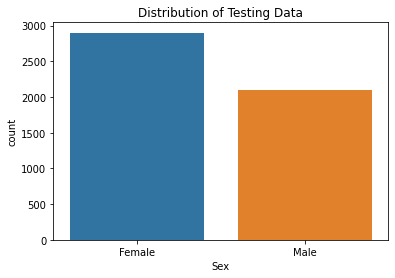

In [ ]:
sns.countplot(x="Sex", data = testing_labels).set(title = "Distribution of Testing Data")

### Image Averaging

In [ ]:
n_img = 20000
img_array = np.zeros((n_img, 100,100))

for k in range(n_img):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = resize(im, (100,100) )
    im = np.mean(im, axis=2) # average the last channel
    img_array[k,:,:] = im

Text(0.5, 1.0, 'Avg(Female)')

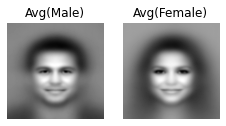

In [ ]:
# Plot the average male and female images
plt.figure(figsize=(10,5))

plt.subplot(2,5,1)
is_male = attribute["Male"][:n_img]==1
plt.imshow(np.mean(img_array[is_male,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(Male)")

plt.subplot(2,5,2)
is_male = attribute["Male"][:n_img]==-1
plt.imshow(np.mean(img_array[is_male,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(Female)")


# Main Driver Code

### Data Preprocessing Functions

In [ ]:
def preprocessing(n_img,pixel_value,contrast = False):
    img_array = np.zeros((n_img*2, pixel_value, pixel_value))

    for k in range(n_img):
        im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
        im = im[20:]
        im = im[0:-20]
        im = np.delete(im, slice(0,20), 1)
        im = np.delete(im, slice(138,158), 1)
        im = resize(im, (pixel_value,pixel_value) )
        im = np.mean(im, axis=2) # average the last channel
        if contrast == True:
            im = exposure.rescale_intensity(im)*255
        img_array[k,:,:] = im
        im = np.fliplr(im) # mirror image
        img_array[k+n_img,:,:] = im

    test_n_img = 5000
    test_img_array = np.zeros((test_n_img, pixel_value, pixel_value))

    for k in range(test_n_img):
        im = imageio.imread(os.path.join(path, all_img[k+15000])).astype(float)
        im = im[20:]
        im = im[0:-20]
        im = np.delete(im, slice(0,20), 1)
        im = np.delete(im, slice(138,158), 1)
        im = resize(im, (pixel_value,pixel_value) )
        im = np.mean(im, axis=2) # average the last channel
        if contrast == True:
            im = exposure.rescale_intensity(im)*255
        test_img_array[k,:,:] = im

    X_train = img_array[0:n_img*2].reshape(n_img*2,pixel_value*pixel_value)/255 
    Y_train = jnp.array(attribute["Male"][0:n_img])
    Y_train = jnp.append(Y_train, Y_train)
    X_test = test_img_array.reshape(test_n_img,pixel_value*pixel_value)/255
    Y_test = jnp.array(attribute["Male"][15000:20000])

    return X_train,Y_train,X_test,Y_test

def preprocessing_RGB(n_img,pixel_value):
    img_array = np.zeros((n_img*2, pixel_value*3*pixel_value))

    for k in range(n_img):
        im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
        im = im[20:]
        im = im[0:-20]
        im = np.delete(im, slice(0,20), 1)
        im = np.delete(im, slice(138,158), 1)
        im = resize(im, (pixel_value,pixel_value,3) )
        im_mirror = np.fliplr(im)
        im = im.flatten()
        img_array[k,:] = im
        im_mirror = im_mirror.flatten()
        img_array[k+n_img,:] = im_mirror

    test_n_img = 5000
    test_img_array = np.zeros((test_n_img, pixel_value*3*pixel_value))

    for k in range(test_n_img):
        im = imageio.imread(os.path.join(path, all_img[k+15000])).astype(float)
        im = im[20:]
        im = im[0:-20]
        im = np.delete(im, slice(0,20), 1)
        im = np.delete(im, slice(138,158), 1)
        im = resize(im, (pixel_value,pixel_value,3) )
        im = im.flatten()
        test_img_array[k,:] = im

    X_train = img_array[0:n_img*2]/255
    Y_train = jnp.array(attribute["Male"][0:n_img])
    Y_train = jnp.append(Y_train, Y_train)
    X_test = test_img_array/255
    Y_test = jnp.array(attribute["Male"][15000:20000])

    return X_train,Y_train,X_test,Y_test

def preprocessing_facepart(n_img,pixel_value):
    hair_array = np.zeros((n_img*2, pixel_value*3*pixel_value))
    eyes_array = np.zeros((n_img*2, pixel_value*3*pixel_value))
    nose_array = np.zeros((n_img*2, pixel_value*3*pixel_value))
    jaw_array = np.zeros((n_img*2, pixel_value*3*pixel_value))

    for k in range(n_img):
        im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
        im = im[20:]
        im = im[0:-20]
        im = np.delete(im, slice(0,20), 1)
        im = np.delete(im, slice(138,158), 1)
        im = resize(im, (pixel_value,pixel_value,3) )

        im_hair = im[:40] # Cropping hair
        im_hair = resize(im_hair, (pixel_value,pixel_value,3) )
        im_hair_mir = np.fliplr(im_hair) # mirror image
        im_hair = im_hair.flatten()
        hair_array[k,:] = im_hair
        im_hair_mir = im_hair_mir.flatten()
        hair_array[k+n_img,:] = im_hair_mir

        im_eyes = im[40:60] # Cropping eye
        im_eyes = resize(im_eyes, (pixel_value,pixel_value,3) )
        im_eyes_mir = np.fliplr(im_eyes) # mirror image
        im_eyes = im_eyes.flatten()
        eyes_array[k,:] = im_eyes
        im_eyes_mir = im_eyes_mir.flatten()
        eyes_array[k+n_img,:] = im_eyes_mir

        im_nose = im[60:70] # Cropping nose
        im_nose = resize(im_nose, (pixel_value,pixel_value,3) )
        im_nose_mir = np.fliplr(im_nose) # mirror image
        im_nose = im_nose.flatten()
        nose_array[k,:] = im_nose
        im_nose_mir = im_nose_mir.flatten()
        nose_array[k+n_img,:] = im_nose_mir

        im_jaw = im[70:100] # Cropping jaw
        im_jaw = resize(im_jaw, (pixel_value,pixel_value,3) )
        im_jaw_mir = np.fliplr(im_jaw) # mirror image
        im_jaw = im_jaw.flatten()
        jaw_array[k,:] = im_jaw
        im_jaw_mir = im_jaw_mir.flatten()
        jaw_array[k+n_img,:] = im_jaw_mir

    test_n_img = 5000
    test_hair_array = np.zeros((test_n_img, pixel_value*3*pixel_value))
    test_eyes_array = np.zeros((test_n_img, pixel_value*3*pixel_value))
    test_nose_array = np.zeros((test_n_img, pixel_value*3*pixel_value))
    test_jaw_array = np.zeros((test_n_img, pixel_value*3*pixel_value))

    for k in range(test_n_img):
        im = imageio.imread(os.path.join(path, all_img[k+15000])).astype(float)
        im = im[20:]
        im = im[0:-20]
        im = np.delete(im, slice(0,20), 1)
        im = np.delete(im, slice(138,158), 1)
        im = resize(im, (pixel_value,pixel_value,3) )

        im_hair = im[:40] # Cropping hair
        im_hair = resize(im_hair, (pixel_value,pixel_value,3) )
        im_hair = im_hair.flatten()
        test_hair_array[k,:] = im_hair

        im_eyes = im[40:60] # Cropping eye
        im_eyes = resize(im_eyes, (pixel_value,pixel_value,3) )
        im_eyes = im_eyes.flatten()
        test_eyes_array[k,:] = im_eyes

        im_nose = im[60:70] # Cropping nose
        im_nose = resize(im_nose, (pixel_value,pixel_value,3) )
        im_nose = im_nose.flatten()
        test_nose_array[k,:] = im_nose

        im_jaw = im[70:100] # Cropping jaw
        im_jaw = resize(im_jaw, (pixel_value,pixel_value,3) )
        im_jaw = im_jaw.flatten()
        test_jaw_array[k,:] = im_jaw

    X_train_hair = hair_array[0:n_img*2]/255
    X_train_eyes = eyes_array[0:n_img*2]/255
    X_train_nose = nose_array[0:n_img*2]/255
    X_train_jaw = jaw_array[0:n_img*2]/255
    Y_train = jnp.array(attribute["Male"][0:n_img])
    Y_train = jnp.append(Y_train, Y_train)

    X_test_hair = test_hair_array/255
    X_test_eyes = test_eyes_array/255
    X_test_nose = test_nose_array/255
    X_test_jaw = test_jaw_array/255
    Y_test = jnp.array(attribute["Male"][15000:20000])
    
    return X_train_hair,X_train_eyes,X_train_nose,X_train_jaw,Y_train,X_test_hair,X_test_eyes,X_test_nose,X_test_jaw,Y_test

### Functions to compute error

In [ ]:
@jax.jit
def compute_error_rate(beta, X, Y):
    # compute predictions
    pred_bool = prediction_batch(beta, X) > 0.5
    
    # convert to +1/-1 predictions
    pred = 2*pred_bool - 1
    
    # return the error rate
    return jnp.mean(Y == pred)

def predict(beta, X):
    pred_bool = prediction_batch(beta, X) > 0.5
    
    # convert to +1/-1 predictions
    pred = 2*pred_bool - 1

    return pred

In [ ]:
def prediction(beta, x):
    proba = 1. / (1. + jnp.exp(-jnp.dot(x,beta)))

    return proba

prediction_batch = jax.vmap(prediction, in_axes=(None, 0))

In [ ]:
# default loss function 
def loss_single(beta, x, y):
    return jnp.log(1. + jnp.exp(-y*jnp.dot(x, beta)))

# L1 regularization
def l1_loss_single(beta, x, y):
    lamb = 0.01
    return jnp.log(1. + jnp.exp(-y * jnp.dot(x, beta))) + lamb*jnp.linalg.norm(jnp.abs(beta), 1)

# L2 regularization
def l2_loss_single(beta, x, y):
    lamb = 0.05
    return jnp.log(1. + jnp.exp(-y * jnp.dot(x, beta))) + lamb*jnp.linalg.norm(jnp.abs(beta), 2)

loss_batch = jax.vmap(loss_single, in_axes=(None, 0, 0))
l1_loss_batch = jax.vmap(l1_loss_single, in_axes=(None, 0, 0))
l2_loss_batch = jax.vmap(l2_loss_single, in_axes=(None, 0, 0))

In [ ]:
@jax.jit
def loss_LR(beta, X, Y):
    losses = loss_batch(beta, X, Y)
    return jnp.mean(losses)

def l1_loss_LR(beta, X, Y):
    losses = l1_loss_batch(beta, X, Y)
    return jnp.mean(losses)
    
def l2_loss_LR(beta, X, Y):
    losses = l2_loss_batch(beta, X, Y)
    return jnp.mean(losses)

# compute derivates
loss_LR_values_and_grad = jax.jit(jax.value_and_grad(loss_LR, argnums=0))
l1_loss_LR_values_and_grad = jax.jit(jax.value_and_grad(l1_loss_LR, argnums=0))
l2_loss_LR_values_and_grad = jax.jit(jax.value_and_grad(l2_loss_LR, argnums=0))

### Stochastic Gradient Descent (SGD) Implementation

In [ ]:
def train_SGD(beta_init,X_train,Y_train,X_test,Y_test,learning_rate_init = 0.01, regularization = 0, minibatch_size = 20, n_epoch = 31):

    N = len(X_train)  #10000, total number of images
    img_indices = np.arange(N)
    loss_history = []
    loss_history_end_epoch = []
    train_acc_hist = []
    test_acc_hist = []
    beta = np.copy(beta_init)
    learning_rate = learning_rate_init

    for epoch in range(n_epoch):
        # go through all the minibatches, sequentially
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)
        
        # Step Decay
        if epoch % 5 == 0:
            learning_rate/=2
            
        all_loss_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = X_train[batch_indices]
            Y_minibatch = Y_train[batch_indices]

            # compute the stochastic gradient
            if regularization == 0:
                val, grad = loss_LR_values_and_grad(beta, X_minibatch, Y_minibatch)
            elif regularization == 1:
                val, grad = l1_loss_LR_values_and_grad(beta, X_minibatch, Y_minibatch)
            elif regularization == 2:
                val, grad = l2_loss_LR_values_and_grad(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad
            
            # book-keeping
            loss_history.append(val)
            all_loss_within_epoch.append(val)

        loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
        
        err_train = 100*compute_error_rate(beta, X_train, Y_train)
        err_val= 100*compute_error_rate(beta, X_test, Y_test)    
        train_acc_hist.append(err_train)
        test_acc_hist.append(err_val)

        if epoch % 5 == 0:
            # let us compute the train/validation error rate every 5 epochs
            print(f"Epoch:{epoch} \t Loss:{val:2.3f} \t Training Accuracy:{err_train:2.1f}% \t Testing Accuracy:{err_val:2.1f}%")

    err_val= 100*compute_error_rate(beta, X_test, Y_test)
    prediction = predict(beta, X_test)
    return loss_history_end_epoch, train_acc_hist, test_acc_hist, prediction

# Tuning Parameters

In [ ]:
# global for 100 x 100, is changed locally for resolution
beta_standard_dev = 1. / 100.

### Varying Training Samples

In [ ]:
start_time = time.time()
num_data = 15000
print("Number of photos: ", num_data)
X_train,Y_train,X_test,Y_test = preprocessing(num_data, 100)
print("--- Finished in %s seconds ---" % (time.time() - start_time))

Number of photos:  15000
--- Finished in 9445.071624279022 seconds ---


In [ ]:
lst = [1000,5000,10000,15000]
train_acc_lst = []
test_acc_lst = []

for num in lst:
    start_time = time.time()
    print("number of samples: ", num)
    #X_train,Y_train,X_test,Y_test = preprocessing(num, 100)
    cX_train, cY_train = np.append(X_train[0:num], X_train[num_data:num_data+num], axis=0), np.append(Y_train[0:num], Y_train[num_data:num_data+num], axis=0)
    beta_init = np.random.normal(0, beta_standard_dev, 100*100)
    loss_hist, train_acc, test_acc, pred = train_SGD(beta_init, cX_train, cY_train, X_test, Y_test)
    train_acc_lst.append(train_acc)
    test_acc_lst.append(test_acc)
    print("--- Finished in %s seconds ---" % (time.time() - start_time))

number of samples:  1000
Epoch:0 	 Loss:0.852 	 Training Accuracy:61.4% 	 Testing Accuracy:59.0%
Epoch:5 	 Loss:0.358 	 Training Accuracy:82.0% 	 Testing Accuracy:80.1%
Epoch:10 	 Loss:0.484 	 Training Accuracy:84.7% 	 Testing Accuracy:82.3%
Epoch:15 	 Loss:0.657 	 Training Accuracy:85.9% 	 Testing Accuracy:83.6%
Epoch:20 	 Loss:0.386 	 Training Accuracy:86.6% 	 Testing Accuracy:83.7%
Epoch:25 	 Loss:0.479 	 Training Accuracy:86.4% 	 Testing Accuracy:83.7%
Epoch:30 	 Loss:0.313 	 Training Accuracy:86.4% 	 Testing Accuracy:83.7%
--- Finished in 9.750754356384277 seconds ---
number of samples:  5000
Epoch:0 	 Loss:0.484 	 Training Accuracy:72.1% 	 Testing Accuracy:72.4%
Epoch:5 	 Loss:0.355 	 Training Accuracy:88.4% 	 Testing Accuracy:88.3%
Epoch:10 	 Loss:0.252 	 Training Accuracy:89.4% 	 Testing Accuracy:89.8%
Epoch:15 	 Loss:0.336 	 Training Accuracy:89.3% 	 Testing Accuracy:88.8%
Epoch:20 	 Loss:0.350 	 Training Accuracy:89.8% 	 Testing Accuracy:89.9%
Epoch:25 	 Loss:0.155 	 Training

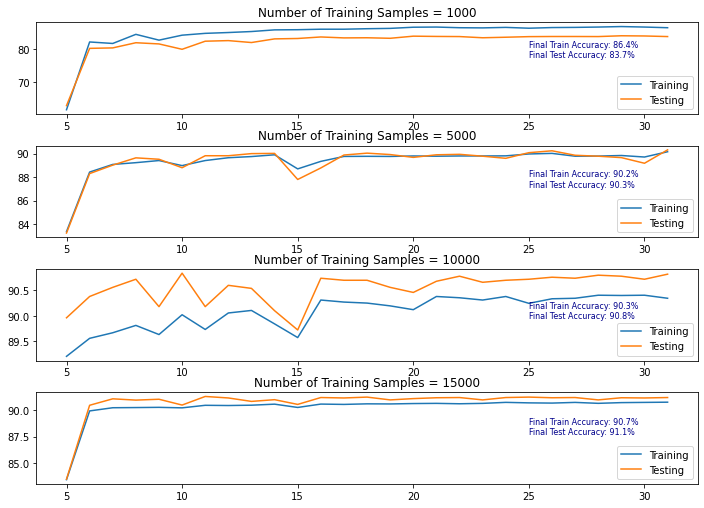

In [ ]:
num_variations = len(lst)
text_height = [9, 3, 0.4, 3]
fig, axs = plt.subplots(num_variations, figsize=(10,7))
fig.tight_layout()
for i in range(num_variations):
    axs[i].plot(np.arange(5,32), train_acc_lst[i][4:], label = "Training")
    axs[i].plot(np.arange(5,32), test_acc_lst[i][4:], label = "Testing")
    axs[i].annotate(f"Final Train Accuracy: {train_acc_lst[i][30]:2.1f}% \nFinal Test Accuracy: {test_acc_lst[i][30]:2.1f}%", xy=(25,train_acc_lst[i][30]-text_height[i]), fontsize=8, color='darkblue')
    axs[i].set_title(f"Number of Training Samples = {lst[i]}")
    axs[i].legend()

### Varying Image Resolution

In [ ]:
lst = [75,100,125]
train_acc_lst = []
test_acc_lst = []

for res in lst:
    print("resolution: ",res)
    start_time = time.time()
    X_train,Y_train,X_test,Y_test = preprocessing(7500,res)
    beta_init = np.random.normal(0,beta_standard_dev,res*res)
    loss_hist, train_acc, test_acc, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test)
    train_acc_lst.append(train_acc)
    test_acc_lst.append(test_acc)
    print("--- Finished in %s seconds ---" % (time.time() - start_time))

resolution:  75
Epoch:0 	 Loss:0.480 	 Training Accuracy:74.0% 	 Testing Accuracy:74.8%
Epoch:5 	 Loss:0.287 	 Training Accuracy:87.3% 	 Testing Accuracy:88.3%
Epoch:10 	 Loss:0.374 	 Training Accuracy:84.6% 	 Testing Accuracy:84.8%
Epoch:15 	 Loss:0.393 	 Training Accuracy:89.1% 	 Testing Accuracy:89.9%
Epoch:20 	 Loss:0.344 	 Training Accuracy:88.9% 	 Testing Accuracy:89.9%
Epoch:25 	 Loss:0.260 	 Training Accuracy:88.8% 	 Testing Accuracy:89.4%
Epoch:30 	 Loss:0.321 	 Training Accuracy:88.9% 	 Testing Accuracy:89.8%
--- Finished in 166.80697202682495 seconds ---
resolution:  100
Epoch:0 	 Loss:0.552 	 Training Accuracy:79.4% 	 Testing Accuracy:80.6%
Epoch:5 	 Loss:0.207 	 Training Accuracy:87.6% 	 Testing Accuracy:88.4%
Epoch:10 	 Loss:0.176 	 Training Accuracy:89.8% 	 Testing Accuracy:90.5%
Epoch:15 	 Loss:0.287 	 Training Accuracy:90.0% 	 Testing Accuracy:90.4%
Epoch:20 	 Loss:0.139 	 Training Accuracy:90.1% 	 Testing Accuracy:90.6%
Epoch:25 	 Loss:0.346 	 Training Accuracy:90.2% 

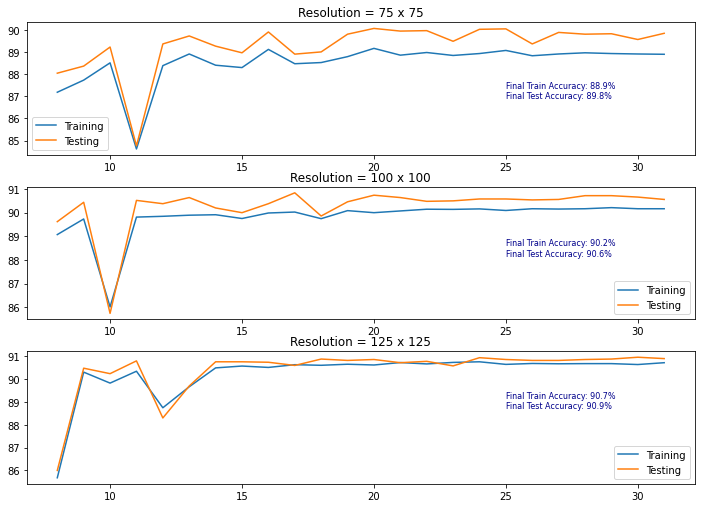

In [ ]:
num_variations = len(lst)
text_height = [2, 2, 2]
fig, axs = plt.subplots(num_variations, figsize=(10,7))
fig.tight_layout()
for i in range(num_variations):
    axs[i].plot(np.arange(8,32), train_acc_lst[i][7:], label = "Training")
    axs[i].plot(np.arange(8,32), test_acc_lst[i][7:], label = "Testing")
    axs[i].annotate(f"Final Train Accuracy: {train_acc_lst[i][30]:2.1f}% \nFinal Test Accuracy: {test_acc_lst[i][30]:2.1f}%", xy=(25,train_acc_lst[i][30]-text_height[i]), fontsize=8, color='darkblue')
    axs[i].set_title(f"Resolution = {lst[i]} x {lst[i]}")
    axs[i].legend()

### Balancing Data

In [ ]:
X_train,Y_train,X_test,Y_test = preprocessing(10000,100)

In [ ]:
def rebalance(X_array, Y_array): 
    femalesOver = sum(Y_array) * -1
    genderToReduce = -1

    if femalesOver < 0:
        genderToReduce = 1     # if for some reason males > females, we will reduce the number of males

    femalesWhere = np.where(Y_array == genderToReduce)[0]
    indexToDelete = np.random.choice(femalesWhere, size=femalesOver, replace=False)

    new_X_array = np.delete(X_array, indexToDelete, 0)
    new_Y_array = np.delete(Y_array, indexToDelete)
    return new_X_array, new_Y_array

In [ ]:
X_train, Y_train = rebalance(X_train, Y_train)  # do this to balance male and female (num of datapoints will decrease)

In [ ]:
# balanced   training data
# imbalanced testing data
# varied learning rate to see what it changes
X_train, Y_train = rebalance(X_train, Y_train)

lst = [0.001, 0.01, 0.02, 0.05]
train_acc_lst = []
test_acc_lst = []

for num in lst:
    print("learning rate: ",num)
    beta_init = np.random.normal(0,beta_standard_dev,100*100)
    loss_hist, train_acc, test_acc, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test, learning_rate_init = num, regularization=0)
    train_acc_lst.append(train_acc)
    test_acc_lst.append(test_acc)

learning rate:  0.001
Epoch:0 	 Loss:0.686 	 Training Accuracy:69.8% 	 Testing Accuracy:69.9%
Epoch:5 	 Loss:0.372 	 Training Accuracy:79.5% 	 Testing Accuracy:80.5%
Epoch:10 	 Loss:0.496 	 Training Accuracy:81.8% 	 Testing Accuracy:83.0%
Epoch:15 	 Loss:0.453 	 Training Accuracy:82.5% 	 Testing Accuracy:83.4%
Epoch:20 	 Loss:0.425 	 Training Accuracy:82.8% 	 Testing Accuracy:83.7%
Epoch:25 	 Loss:0.451 	 Training Accuracy:83.1% 	 Testing Accuracy:83.8%
Epoch:30 	 Loss:0.411 	 Training Accuracy:83.2% 	 Testing Accuracy:83.8%
learning rate:  0.01
Epoch:0 	 Loss:0.475 	 Training Accuracy:72.1% 	 Testing Accuracy:76.3%
Epoch:5 	 Loss:0.391 	 Training Accuracy:88.7% 	 Testing Accuracy:89.9%
Epoch:10 	 Loss:0.262 	 Training Accuracy:89.8% 	 Testing Accuracy:90.4%
Epoch:15 	 Loss:0.267 	 Training Accuracy:90.1% 	 Testing Accuracy:90.5%
Epoch:20 	 Loss:0.246 	 Training Accuracy:90.1% 	 Testing Accuracy:90.7%
Epoch:25 	 Loss:0.163 	 Training Accuracy:90.2% 	 Testing Accuracy:90.7%
Epoch:30 	 L

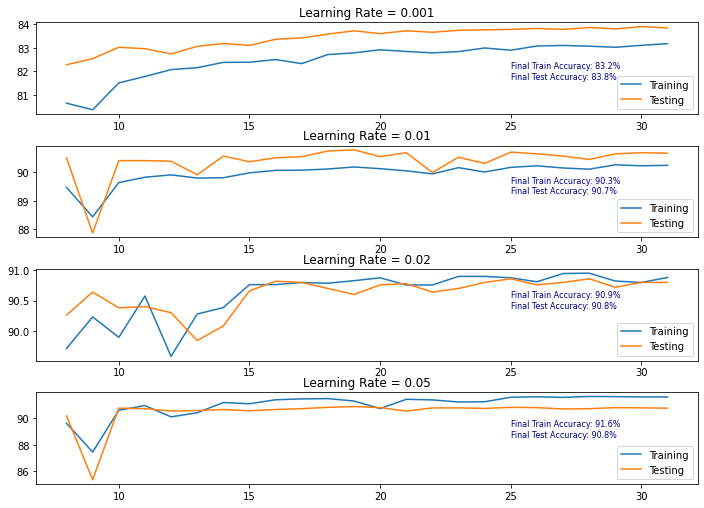

In [ ]:
num_variations = len(lst)
text_height = [1.5, 1, 0.5, 3]
fig, axs = plt.subplots(num_variations, figsize=(10,7))
fig.tight_layout()
for i in range(num_variations):
    axs[i].plot(np.arange(8,32), train_acc_lst[i][7:], label = "Training")
    axs[i].plot(np.arange(8,32), test_acc_lst[i][7:], label = "Testing")
    axs[i].annotate(f"Final Train Accuracy: {train_acc_lst[i][30]:2.1f}% \nFinal Test Accuracy: {test_acc_lst[i][30]:2.1f}%", xy=(25,train_acc_lst[i][30]-text_height[i]), fontsize=8, color='darkblue')
    axs[i].set_title(f"Learning Rate = {lst[i]}")
    axs[i].legend()

### Regularization

In [ ]:
lst = [0,1,2]
train_acc_lst = []
test_acc_lst = []

#X_train,Y_train,X_test,Y_test = preprocessing(10000,100)

for num in lst:
    print("L",num," Regularization")
    beta_init = np.random.normal(0,beta_standard_dev,100*100)
    loss_hist, train_acc, test_acc = train_SGD(beta_init,X_train,Y_train,X_test,Y_test,regularization = num)
    train_acc_lst.append(train_acc)
    test_acc_lst.append(test_acc)

L 0  Regularization
Epoch:0 	 Loss:0.324 	 Training Accuracy:82.9% 	 Testing Accuracy:83.9%
Epoch:5 	 Loss:0.094 	 Training Accuracy:87.9% 	 Testing Accuracy:88.1%
Epoch:10 	 Loss:0.266 	 Training Accuracy:90.0% 	 Testing Accuracy:90.6%
Epoch:15 	 Loss:0.217 	 Training Accuracy:90.1% 	 Testing Accuracy:90.8%
Epoch:20 	 Loss:0.219 	 Training Accuracy:90.4% 	 Testing Accuracy:90.8%
Epoch:25 	 Loss:0.235 	 Training Accuracy:90.3% 	 Testing Accuracy:90.8%
Epoch:30 	 Loss:0.234 	 Training Accuracy:90.3% 	 Testing Accuracy:90.8%
L 1  Regularization
Epoch:0 	 Loss:3.659 	 Training Accuracy:42.2% 	 Testing Accuracy:42.1%
Epoch:5 	 Loss:1.151 	 Training Accuracy:42.2% 	 Testing Accuracy:42.0%
Epoch:10 	 Loss:0.711 	 Training Accuracy:57.8% 	 Testing Accuracy:58.0%
Epoch:15 	 Loss:0.732 	 Training Accuracy:57.8% 	 Testing Accuracy:58.0%
Epoch:20 	 Loss:0.716 	 Training Accuracy:57.8% 	 Testing Accuracy:58.0%
Epoch:25 	 Loss:0.707 	 Training Accuracy:58.8% 	 Testing Accuracy:59.0%
Epoch:30 	 Loss

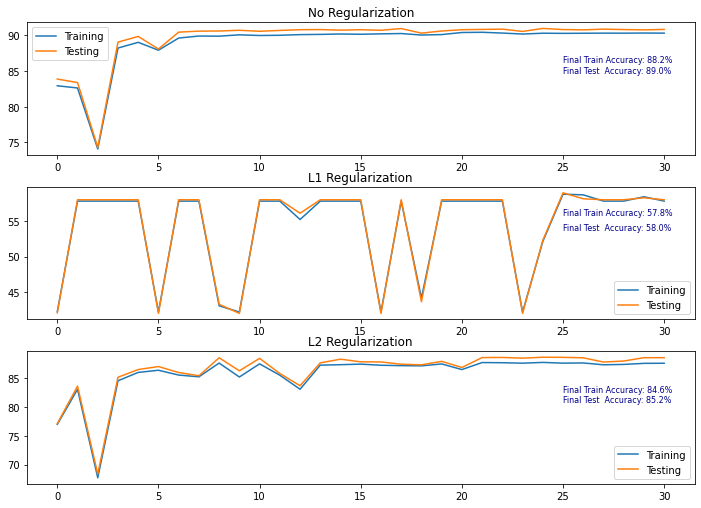

In [ ]:
num_epoch = len(lst)
fig, axs = plt.subplots(num_epoch, figsize=(10,7))
fig.tight_layout()
for i in range(num_epoch):
    axs[i].plot(train_acc_lst[i], label = "Training")
    axs[i].plot(test_acc_lst[i], label = "Testing")
    axs[i].annotate(f"Final Train Accuracy: {train_acc_lst[i][num_epoch]:2.1f}%", xy=(25,train_acc_lst[i][num_epoch]-2), fontsize=8, color='darkblue')
    axs[i].annotate(f"Final Test  Accuracy: {test_acc_lst[i][num_epoch]:2.1f}%", xy=(25,test_acc_lst[i][num_epoch]-4.3), fontsize=8, color='darkblue')
    if (i==0):
        axs[i].set_title(f"No Regularization")
    else:
        axs[i].set_title(f"L{lst[i]} Regularization")
    axs[i].legend()

### Coloured vs Grayscale

In [ ]:
size = 10000
res = 100
train_acc_lst = []
test_acc_lst = []

# Grayscale Image
beta_init = np.random.normal(0,beta_standard_dev,res*res)
X_train,Y_train,X_test,Y_test = preprocessing(size,res)
loss_hist_gray, train_acc, test_acc, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)

Epoch:0 	 Loss:0.547 	 Training Accuracy:72.0% 	 Testing Accuracy:72.2%
Epoch:5 	 Loss:0.356 	 Training Accuracy:88.5% 	 Testing Accuracy:89.3%
Epoch:10 	 Loss:0.238 	 Training Accuracy:90.2% 	 Testing Accuracy:90.8%
Epoch:15 	 Loss:0.237 	 Training Accuracy:90.2% 	 Testing Accuracy:90.8%
Epoch:20 	 Loss:0.326 	 Training Accuracy:90.1% 	 Testing Accuracy:90.5%
Epoch:25 	 Loss:0.175 	 Training Accuracy:90.2% 	 Testing Accuracy:90.6%
Epoch:30 	 Loss:0.282 	 Training Accuracy:90.4% 	 Testing Accuracy:90.7%


In [ ]:
# RGB Image
beta_init = np.random.normal(0,beta_standard_dev,res*3*res)
X_train,Y_train,X_test,Y_test = preprocessing_RGB(size,res)
loss_hist_2, train_acc, test_acc, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)

Epoch:0 	 Loss:0.357 	 Training Accuracy:83.2% 	 Testing Accuracy:83.9%
Epoch:5 	 Loss:0.086 	 Training Accuracy:92.6% 	 Testing Accuracy:91.9%
Epoch:10 	 Loss:0.191 	 Training Accuracy:93.4% 	 Testing Accuracy:92.8%
Epoch:15 	 Loss:0.125 	 Training Accuracy:93.6% 	 Testing Accuracy:92.7%
Epoch:20 	 Loss:0.153 	 Training Accuracy:93.7% 	 Testing Accuracy:93.0%
Epoch:25 	 Loss:0.080 	 Training Accuracy:93.8% 	 Testing Accuracy:92.9%
Epoch:30 	 Loss:0.216 	 Training Accuracy:93.8% 	 Testing Accuracy:92.9%


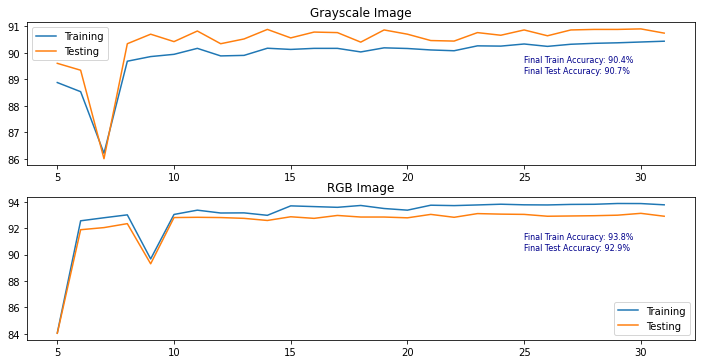

In [ ]:
num_variations = 2
text_height = [1.2, 3.4]
titles = ["Grayscale Image", "RGB Image"]
fig, axs = plt.subplots(num_variations, figsize=(10,5))
fig.tight_layout()
for i in range(num_variations):
    axs[i].plot(np.arange(5,32), train_acc_lst[i][4:], label = "Training")
    axs[i].plot(np.arange(5,32), test_acc_lst[i][4:], label = "Testing")
    axs[i].annotate(f"Final Train Accuracy: {train_acc_lst[i][30]:2.1f}% \nFinal Test Accuracy: {test_acc_lst[i][30]:2.1f}%", xy=(25,train_acc_lst[i][30]-text_height[i]), fontsize=8, color='darkblue')
    axs[i].set_title(titles[i])
    axs[i].legend()

### Adjusting Contrast

In [ ]:
res = 100
size = 10000
train_acc_lst = []
test_acc_lst = []
beta_init = np.random.normal(0,beta_standard_dev,res*res)

start_time = time.time()
print("No Contrast")
X_train,Y_train,X_test,Y_test = preprocessing(size,res)
loss_hist, train_acc, test_acc, pred = train_SGD(beta_init,cX_train,cY_train,X_test,Y_test)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)
print("--- Finished in %s seconds ---" % (time.time() - start_time))

start_time = time.time()
print("Contrast added")
contrast_X_train,contrast_Y_train,X_test,Y_test = preprocessing(size,res,contrast = True)
loss_hist, train_acc, test_acc, pred = train_SGD(beta_init,contrast_X_train,contrast_Y_train,X_test,Y_test)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)
print("--- Finished in %s seconds ---" % (time.time() - start_time))

No Contrast
Epoch:0 	 Loss:0.513 	 Training Accuracy:78.4% 	 Testing Accuracy:78.9%
Epoch:5 	 Loss:0.351 	 Training Accuracy:89.5% 	 Testing Accuracy:90.3%
Epoch:10 	 Loss:0.249 	 Training Accuracy:90.0% 	 Testing Accuracy:90.3%
Epoch:15 	 Loss:0.214 	 Training Accuracy:90.3% 	 Testing Accuracy:90.6%
Epoch:20 	 Loss:0.309 	 Training Accuracy:90.3% 	 Testing Accuracy:90.7%
Epoch:25 	 Loss:0.207 	 Training Accuracy:90.3% 	 Testing Accuracy:90.6%
Epoch:30 	 Loss:0.103 	 Training Accuracy:90.4% 	 Testing Accuracy:90.8%
--- Finished in 45.04216432571411 seconds ---
Contrast added
Epoch:0 	 Loss:0.531 	 Training Accuracy:78.3% 	 Testing Accuracy:78.4%
Epoch:5 	 Loss:0.330 	 Training Accuracy:88.9% 	 Testing Accuracy:89.5%
Epoch:10 	 Loss:0.289 	 Training Accuracy:90.4% 	 Testing Accuracy:90.6%
Epoch:15 	 Loss:0.318 	 Training Accuracy:90.5% 	 Testing Accuracy:91.0%
Epoch:20 	 Loss:0.283 	 Training Accuracy:90.6% 	 Testing Accuracy:90.9%
Epoch:25 	 Loss:0.228 	 Training Accuracy:90.6% 	 Testi

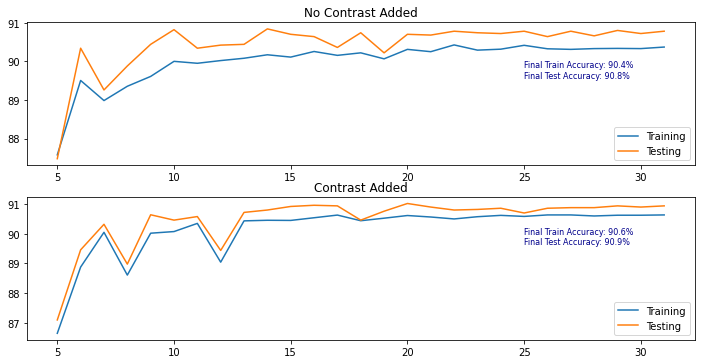

In [ ]:
num_variations = 2
text_height = [0.8, 1]
titles = ["No Contrast Added", "Contrast Added"]
fig, axs = plt.subplots(num_variations, figsize=(10,5))
fig.tight_layout()
for i in range(num_variations):
    axs[i].plot(np.arange(5,32), train_acc_lst[i][4:], label = "Training")
    axs[i].plot(np.arange(5,32), test_acc_lst[i][4:], label = "Testing")
    axs[i].annotate(f"Final Train Accuracy: {train_acc_lst[i][30]:2.1f}% \nFinal Test Accuracy: {test_acc_lst[i][30]:2.1f}%", xy=(25,train_acc_lst[i][30]-text_height[i]), fontsize=8, color='darkblue')
    axs[i].set_title(titles[i])
    axs[i].legend()

Explanation:
    
Adjusting contrast does not make our model better

### Cropped Parts of Face

In [ ]:
res = 100
size = 5000
train_acc_lst = []
test_acc_lst = []

start_time = time.time()
print("Preparing Images")
beta_init = np.random.normal(0,beta_standard_dev,res*3*res)
X_train_hair,X_train_eyes,X_train_nose,X_train_jaw,Y_train,X_test_hair,X_test_eyes,X_test_nose,X_test_jaw,Y_test = preprocessing_facepart(size,res)
print("--- Finished in %s seconds ---" % (time.time() - start_time))

#Hair
start_time = time.time()
print("Using Hair Only")
loss_hist, train_acc, test_acc, pred_hair = train_SGD(beta_init,X_train_hair,Y_train,X_test_hair,Y_test)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)
print("--- Finished in %s seconds ---" % (time.time() - start_time))

#Eyes
start_time = time.time()
print("Using Eyes Only")
loss_hist, train_acc, test_acc, pred_eyes = train_SGD(beta_init,X_train_eyes,Y_train,X_test_eyes,Y_test)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)
print("--- Finished in %s seconds ---" % (time.time() - start_time))

#Nose
start_time = time.time()
print("Using Nose Only")
loss_hist, train_acc, test_acc, pred_nose = train_SGD(beta_init,X_train_nose,Y_train,X_test_nose,Y_test)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)
print("--- Finished in %s seconds ---" % (time.time() - start_time))

#Jaw
start_time = time.time()
print("Using Jaw Only")
loss_hist, train_acc, test_acc, pred_jaw = train_SGD(beta_init,X_train_jaw,Y_train,X_test_jaw,Y_test)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)
print("--- Finished in %s seconds ---" % (time.time() - start_time))

Preparing Images
--- Finished in 196.36127948760986 seconds ---
Using Hair Only
Epoch:0 	 Loss:0.722 	 Training Accuracy:42.6% 	 Testing Accuracy:42.6%
Epoch:5 	 Loss:0.556 	 Training Accuracy:74.3% 	 Testing Accuracy:72.7%
Epoch:10 	 Loss:0.376 	 Training Accuracy:75.7% 	 Testing Accuracy:74.2%
Epoch:15 	 Loss:0.504 	 Training Accuracy:76.3% 	 Testing Accuracy:74.6%
Epoch:20 	 Loss:0.512 	 Training Accuracy:76.6% 	 Testing Accuracy:74.9%
Epoch:25 	 Loss:0.464 	 Training Accuracy:76.6% 	 Testing Accuracy:75.2%
Epoch:30 	 Loss:0.425 	 Training Accuracy:76.5% 	 Testing Accuracy:75.1%
--- Finished in 86.58239912986755 seconds ---
Using Eyes Only
Epoch:0 	 Loss:0.189 	 Training Accuracy:85.8% 	 Testing Accuracy:86.3%
Epoch:5 	 Loss:0.093 	 Training Accuracy:88.5% 	 Testing Accuracy:88.2%
Epoch:10 	 Loss:0.332 	 Training Accuracy:91.6% 	 Testing Accuracy:91.3%
Epoch:15 	 Loss:0.213 	 Training Accuracy:91.7% 	 Testing Accuracy:91.4%
Epoch:20 	 Loss:0.433 	 Training Accuracy:91.8% 	 Testing A

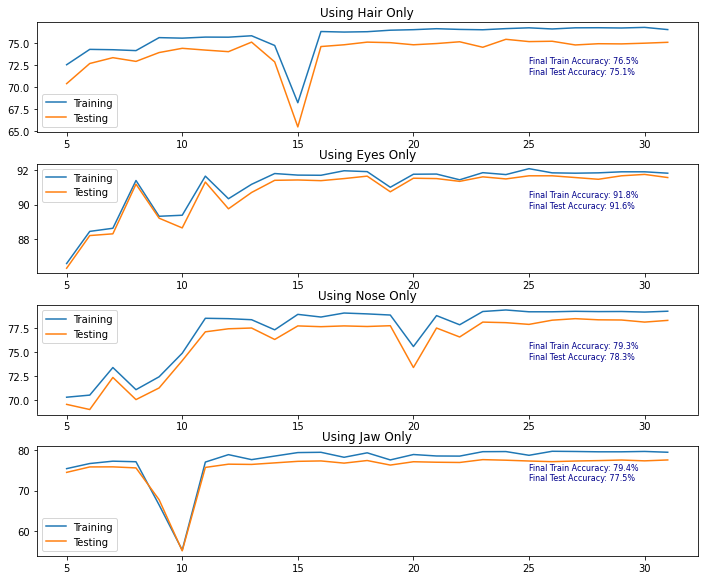

In [ ]:
num_variations = 4
text_height = [5, 2, 5, 7]
graph_titles = ["Hair", "Eyes", "Nose", "Jaw"]
fig, axs = plt.subplots(num_variations, figsize=(10,8))
fig.tight_layout()
for i in range(num_variations):
    axs[i].plot(np.arange(5,32), train_acc_lst[i][4:], label = "Training")
    axs[i].plot(np.arange(5,32), test_acc_lst[i][4:], label = "Testing")
    axs[i].annotate(f"Final Train Accuracy: {train_acc_lst[i][30]:2.1f}% \nFinal Test Accuracy: {test_acc_lst[i][30]:2.1f}%", xy=(25,train_acc_lst[i][30]-text_height[i]), fontsize=8, color='darkblue')
    axs[i].set_title("Using " + graph_titles[i] + " Only")
    axs[i].legend()

### Ensembling with Different Parts of Face

In [ ]:
def aggregate(*pred):
    """
    desc:
    ===
    Takes in arbitrary number of prediction from individual decision trees and output majority class.
    If there is a tie (i.e. 0), break it at random.
    """
    lst = [sum(x) for x in zip(*pred)]
    agg = []
    for i in lst:
        if i == 0:
            n = np.random.uniform(0,1,1)
            if n<0.5:
                agg.append(-1)
            else:
                agg.append(1)
        elif i<0:
            agg.append(-1)
        else:
            agg.append(1)
    return agg
pred = aggregate(pred_hair,pred_eyes,pred_nose,pred_jaw)
acc = accuracy_score(Y_test,pred)
auc = roc_auc_score(Y_test,pred)
print('AUC: ',auc)
print('Accuracy: ', acc)
print(confusion_matrix(Y_test,pred))

AUC:  0.8507459683942009
Accuracy:  0.8602
[[2639  262]
 [ 437 1662]]


# Best Model

In [ ]:
size = 7000
res= 100
train_acc_lst = []
test_acc_lst = []

beta_init = np.random.normal(0,beta_standard_dev,res*3*res)
X_train,Y_train,X_test,Y_test = preprocessing_RGB(size,res)
loss_hist, train_acc, test_acc, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)

Epoch:0 	 Loss:1.131 	 Training Accuracy:83.8% 	 Testing Accuracy:84.4%
Epoch:5 	 Loss:0.249 	 Training Accuracy:88.8% 	 Testing Accuracy:88.4%
Epoch:10 	 Loss:0.081 	 Training Accuracy:93.1% 	 Testing Accuracy:92.1%
Epoch:15 	 Loss:0.102 	 Training Accuracy:93.3% 	 Testing Accuracy:92.2%
Epoch:20 	 Loss:0.193 	 Training Accuracy:93.5% 	 Testing Accuracy:92.3%
Epoch:25 	 Loss:0.176 	 Training Accuracy:93.6% 	 Testing Accuracy:92.5%
Epoch:30 	 Loss:0.247 	 Training Accuracy:93.6% 	 Testing Accuracy:92.5%


In [ ]:
train_acc_lst = []
test_acc_lst = []
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)

In [ ]:
acc = accuracy_score(Y_test,pred)
auc = roc_auc_score(Y_test,pred)
print('AUC: ',auc)
print('Accuracy: ', acc)
print(confusion_matrix(Y_test,pred))

AUC:  0.922130398431715
Accuracy:  0.925
[[2727  174]
 [ 201 1898]]


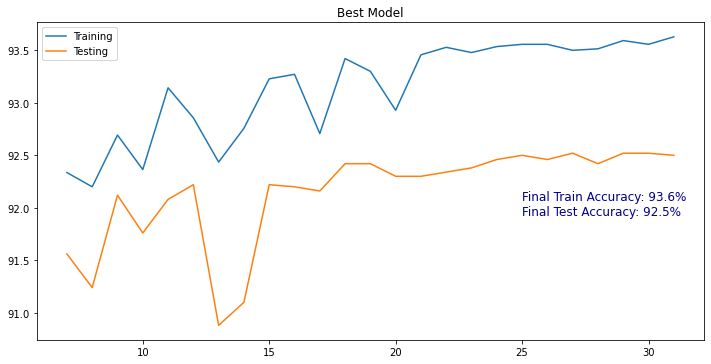

In [ ]:
num_variations = 1
text_height = [1.7]
fig, axs = plt.subplots(num_variations, figsize=(10,5))
fig.tight_layout()
for i in range(num_variations):
    axs.plot(np.arange(7,32), train_acc_lst[i][6:], label = "Training")
    axs.plot(np.arange(7,32), test_acc_lst[i][6:], label = "Testing")
    axs.annotate(f"Final Train Accuracy: {train_acc_lst[i][30]:2.1f}% \nFinal Test Accuracy: {test_acc_lst[i][30]:2.1f}%", xy=(25,train_acc_lst[i][30]-text_height[i]), fontsize=12, color='darkblue')
    axs.set_title("Best Model")
    axs.legend()

In [ ]:
res = 100
size = 200
err_lst = []
beta_standard_dev = 1. / res
beta_init = np.random.normal(0,beta_standard_dev,res*res)
X_train,Y_train,X_test,Y_test = preprocessing(size,res)
loss_hist_gray, err_val_gray, pred_gray = train_SGD(beta_init,X_train,Y_train,X_test,Y_test)
err_lst.append(err_val_gray)

epoch:0 	 Loss:5.822 	 error(train):57.5% 	 error(val):58.0%
epoch:2 	 Loss:1.765 	 error(train):54.8% 	 error(val):53.9%
epoch:4 	 Loss:0.986 	 error(train):78.5% 	 error(val):68.8%
epoch:6 	 Loss:0.686 	 error(train):74.2% 	 error(val):65.4%
epoch:8 	 Loss:0.345 	 error(train):84.0% 	 error(val):74.0%
epoch:10 	 Loss:0.272 	 error(train):84.5% 	 error(val):74.7%
epoch:12 	 Loss:0.347 	 error(train):85.5% 	 error(val):75.2%
epoch:14 	 Loss:0.234 	 error(train):83.8% 	 error(val):73.5%
epoch:16 	 Loss:0.347 	 error(train):88.2% 	 error(val):75.3%
epoch:18 	 Loss:0.423 	 error(train):88.5% 	 error(val):75.9%
epoch:20 	 Loss:0.223 	 error(train):87.8% 	 error(val):75.8%
epoch:22 	 Loss:0.315 	 error(train):87.0% 	 error(val):75.6%
epoch:24 	 Loss:0.176 	 error(train):87.2% 	 error(val):75.4%
epoch:26 	 Loss:0.330 	 error(train):87.8% 	 error(val):75.8%
epoch:28 	 Loss:0.328 	 error(train):86.8% 	 error(val):75.4%
epoch:30 	 Loss:0.243 	 error(train):87.8% 	 error(val):75.5%
epoch:32 	 Lo

# Ensembling with Best Model on 200 images

In [ ]:
res = 100
size = 200
train_acc_lst = []
test_acc_lst = []

start_time = time.time()
print("Preparing Images")
beta_init = np.random.normal(0,beta_standard_dev,res*3*res)
X_train_hair,X_train_eyes,X_train_nose,X_train_jaw,Y_train,X_test_hair,X_test_eyes,X_test_nose,X_test_jaw,Y_test = preprocessing_facepart(size,res)
print("--- Finished in %s seconds ---" % (time.time() - start_time))

#Hair
start_time = time.time()
print("Using Hair Only")
loss_hist, train_acc, test_acc, pred_hair = train_SGD(beta_init,X_train_hair,Y_train,X_test_hair,Y_test)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)
print("--- Finished in %s seconds ---" % (time.time() - start_time))

#Eyes
start_time = time.time()
print("Using Eyes Only")
loss_hist, train_acc, test_acc, pred_eyes = train_SGD(beta_init,X_train_eyes,Y_train,X_test_eyes,Y_test)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)
print("--- Finished in %s seconds ---" % (time.time() - start_time))

#Nose
start_time = time.time()
print("Using Nose Only")
loss_hist, train_acc, test_acc, pred_nose = train_SGD(beta_init,X_train_nose,Y_train,X_test_nose,Y_test)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)
print("--- Finished in %s seconds ---" % (time.time() - start_time))

#Jaw
start_time = time.time()
print("Using Jaw Only")
loss_hist, train_acc, test_acc, pred_jaw = train_SGD(beta_init,X_train_jaw,Y_train,X_test_jaw,Y_test)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)
print("--- Finished in %s seconds ---" % (time.time() - start_time))

Preparing Images
--- Finished in 126.45703101158142 seconds ---
Using Hair Only
Epoch:0 	 Loss:2.262 	 Training Accuracy:57.5% 	 Testing Accuracy:58.0%
Epoch:5 	 Loss:1.024 	 Training Accuracy:61.0% 	 Testing Accuracy:53.8%
Epoch:10 	 Loss:0.425 	 Training Accuracy:70.2% 	 Testing Accuracy:62.6%
Epoch:15 	 Loss:0.592 	 Training Accuracy:78.8% 	 Testing Accuracy:64.4%
Epoch:20 	 Loss:0.419 	 Training Accuracy:79.0% 	 Testing Accuracy:64.4%
Epoch:25 	 Loss:0.475 	 Training Accuracy:78.8% 	 Testing Accuracy:63.9%
Epoch:30 	 Loss:0.405 	 Training Accuracy:79.8% 	 Testing Accuracy:64.1%
--- Finished in 16.14425754547119 seconds ---
Using Eyes Only
Epoch:0 	 Loss:2.903 	 Training Accuracy:42.5% 	 Testing Accuracy:42.0%
Epoch:5 	 Loss:0.430 	 Training Accuracy:85.2% 	 Testing Accuracy:80.9%
Epoch:10 	 Loss:0.133 	 Training Accuracy:89.8% 	 Testing Accuracy:83.5%
Epoch:15 	 Loss:0.298 	 Training Accuracy:91.2% 	 Testing Accuracy:84.1%
Epoch:20 	 Loss:0.361 	 Training Accuracy:91.8% 	 Testing A

In [ ]:
def aggregate(*pred):
    """
    desc:
    ===
    Takes in arbitrary number of prediction from individual decision trees and output majority class.
    If there is a tie (i.e. 0), break it at random.
    """
    lst = [sum(x) for x in zip(*pred)]
    agg = []
    for i in lst:
        if i == 0:
            n = np.random.uniform(0,1,1)
            if n<0.5:
                agg.append(-1)
            else:
                agg.append(1)
        elif i<0:
            agg.append(-1)
        else:
            agg.append(1)
        
    return agg
pred = aggregate(pred_hair,pred_eyes,pred_nose,pred_jaw)
acc = accuracy_score(Y_test,pred)
auc = roc_auc_score(Y_test,pred)
print("Scores Using an Ensemble Model")
print('AUC: ',auc)
print('Accuracy: ', acc)
print(confusion_matrix(Y_test,pred))

Scores Using an Ensemble Model
AUC:  0.7622959111699257
Accuracy:  0.7798
[[2528  373]
 [ 728 1371]]


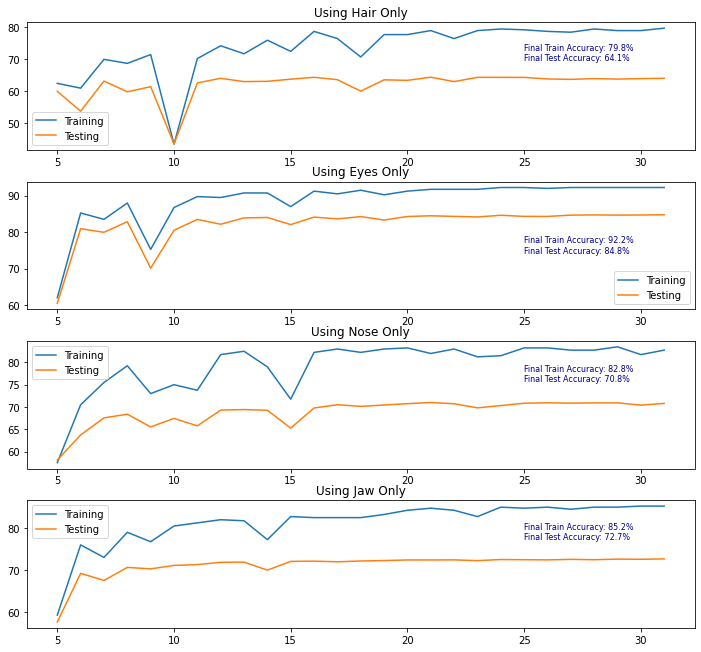

In [ ]:
num_variations = 4
text_height = [10, 18, 7, 8]
graph_titles = ["Hair", "Eyes", "Nose", "Jaw"]
fig, axs = plt.subplots(num_variations, figsize=(10,9))
fig.tight_layout()
for i in range(num_variations):
    axs[i].plot(np.arange(5,32), train_acc_lst[i][4:], label = "Training")
    axs[i].plot(np.arange(5,32), test_acc_lst[i][4:], label = "Testing")
    axs[i].annotate(f"Final Train Accuracy: {train_acc_lst[i][30]:2.1f}% \nFinal Test Accuracy: {test_acc_lst[i][30]:2.1f}%", xy=(25,train_acc_lst[i][30]-text_height[i]), fontsize=8, color='darkblue')
    axs[i].set_title("Using " + graph_titles[i] + " Only")
    axs[i].legend()

In [ ]:
pred_lst = [pred_hair, pred_eyes, pred_nose, pred_jaw]

for i in range(4):
    acc = accuracy_score(Y_test,pred_lst[i])
    auc = roc_auc_score(Y_test,pred_lst[i])
    print("===")
    print("Scores Using "+graph_titles[i]+" Only")
    print('AUC: ',auc)
    print('Accuracy: ', acc)
    print(confusion_matrix(Y_test,pred_lst[i]))

===
Scores Using Hair Only
AUC:  0.6269021590524468
Accuracy:  0.6408
[[2070  831]
 [ 965 1134]]
===
Scores Using Eyes Only
AUC:  0.8417974186752643
Accuracy:  0.8476
[[2547  354]
 [ 408 1691]]
===
Scores Using Nose Only
AUC:  0.6867229991990736
Accuracy:  0.708
[[2377  524]
 [ 936 1163]]
===
Scores Using Jaw Only
AUC:  0.7043983124874059
Accuracy:  0.7266
[[2445  456]
 [ 911 1188]]


# Best Model on 200 Images

In [ ]:
size = 200
res=100
train_acc_lst = []
test_acc_lst = []

beta_init = np.random.normal(0,beta_standard_dev,res*3*res)
X_train,Y_train,X_test,Y_test = preprocessing_RGB(size,res)

loss_hist_2, train_acc, test_acc, pred0 = train_SGD(beta_init,X_train,Y_train,X_test,Y_test, regularization = 0)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)

loss_hist_2, train_acc, test_acc, pred1 = train_SGD(beta_init,X_train,Y_train,X_test,Y_test, regularization = 1)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)

loss_hist_2, train_acc, test_acc, pred2 = train_SGD(beta_init,X_train,Y_train,X_test,Y_test, regularization = 2)
train_acc_lst.append(train_acc)
test_acc_lst.append(test_acc)

Epoch:0 	 Loss:3.522 	 Training Accuracy:63.8% 	 Testing Accuracy:59.2%
Epoch:5 	 Loss:0.230 	 Training Accuracy:83.2% 	 Testing Accuracy:73.6%
Epoch:10 	 Loss:0.252 	 Training Accuracy:85.8% 	 Testing Accuracy:75.6%
Epoch:15 	 Loss:0.194 	 Training Accuracy:90.8% 	 Testing Accuracy:78.7%
Epoch:20 	 Loss:0.217 	 Training Accuracy:90.8% 	 Testing Accuracy:79.0%
Epoch:25 	 Loss:0.261 	 Training Accuracy:91.2% 	 Testing Accuracy:79.1%
Epoch:30 	 Loss:0.319 	 Training Accuracy:92.0% 	 Testing Accuracy:79.4%
Epoch:0 	 Loss:4.040 	 Training Accuracy:57.5% 	 Testing Accuracy:58.1%
Epoch:5 	 Loss:1.846 	 Training Accuracy:68.2% 	 Testing Accuracy:61.7%
Epoch:10 	 Loss:1.395 	 Training Accuracy:84.8% 	 Testing Accuracy:75.7%
Epoch:15 	 Loss:1.135 	 Training Accuracy:87.2% 	 Testing Accuracy:77.8%
Epoch:20 	 Loss:1.109 	 Training Accuracy:87.8% 	 Testing Accuracy:78.3%
Epoch:25 	 Loss:1.080 	 Training Accuracy:87.5% 	 Testing Accuracy:78.5%
Epoch:30 	 Loss:1.032 	 Training Accuracy:88.0% 	 Testi

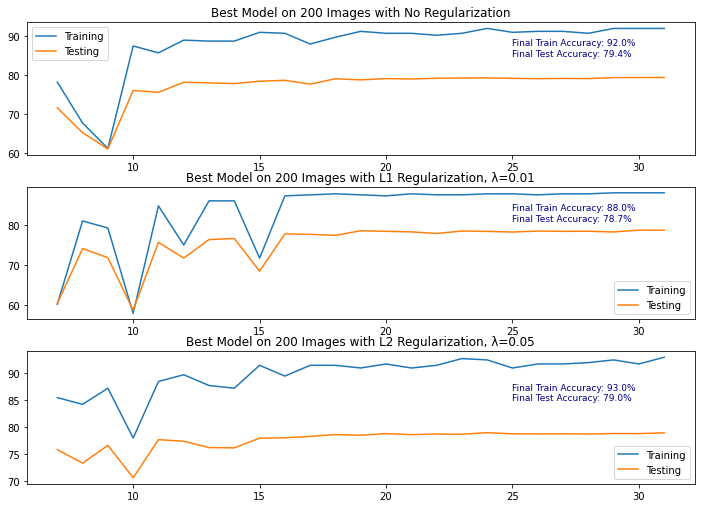

In [ ]:
num_variations = 3
graph_titles = ["No Regularization", "L1 Regularization, λ=0.01", "L2 Regularization, λ=0.05"]
text_height = [7,7,8]
fig, axs = plt.subplots(num_variations, figsize=(10,7))
fig.tight_layout()
for i in range(num_variations):
    axs[i].plot(np.arange(7,32), train_acc_lst[i][6:], label = "Training")
    axs[i].plot(np.arange(7,32), test_acc_lst[i][6:], label = "Testing")
    axs[i].annotate(f"Final Train Accuracy: {train_acc_lst[i][30]:2.1f}% \nFinal Test Accuracy: {test_acc_lst[i][30]:2.1f}%", xy=(25,train_acc_lst[i][30]-text_height[i]), fontsize=9, color='darkblue')
    axs[i].set_title("Best Model on 200 Images with " + graph_titles[i])
    axs[i].legend()

In [ ]:
pred_lst = [pred0, pred1, pred2]

for i in range(3):
    acc = accuracy_score(Y_test,pred_lst[i])
    auc = roc_auc_score(Y_test,pred_lst[i])
    print("===")
    print("Scores with "+graph_titles[i])
    print('AUC: ',auc)
    print('Accuracy: ', acc)
    print(confusion_matrix(Y_test,pred_lst[i]))


===
Scores with No Regularization
AUC:  0.7802371871899735
Accuracy:  0.7942
[[2516  385]
 [ 644 1455]]
===
Scores with L1 Regularization, λ=0.01
AUC:  0.7718592379720223
Accuracy:  0.787
[[2513  388]
 [ 677 1422]]
===
Scores with L2 Regularization, λ=0.05
AUC:  0.7762071825867409
Accuracy:  0.7896
[[2494  407]
 [ 645 1454]]


# Appendix 

Other code used to generate figures for explanations in the report

(-0.5, 177.5, 217.5, -0.5)

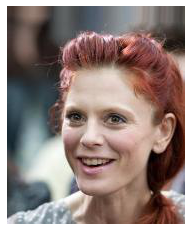

In [ ]:
## Fig 1.x ##
pixel_value = 100
im_or = imageio.imread(os.path.join(path, all_img[1])).astype(float)
plt.imshow(im_or/255)

plt.axis("off")

(-0.5, 137.5, 177.5, -0.5)

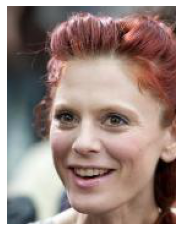

In [ ]:
## Fig 1.x ##
im = im_or[20:]
im = im[0:-20]
im = np.delete(im, slice(0,20), 1)
im = np.delete(im, slice(138,158), 1)
plt.imshow(im/255)
plt.axis("off")

(-0.5, 137.5, 177.5, -0.5)

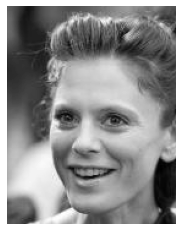

In [ ]:
im_gray = np.mean(im, axis=2)
plt.imshow(im_gray/255., cmap="gray")
plt.axis("off")

(-0.5, 99.5, 99.5, -0.5)

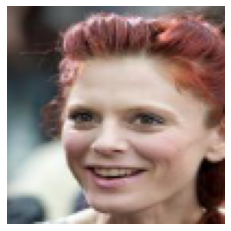

In [ ]:
im_rescaled = resize(im, (100,100,3))
plt.imshow(im_rescaled/255)
plt.axis("off")

(-0.5, 137.5, 177.5, -0.5)

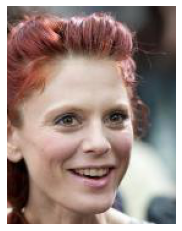

In [ ]:
im_mirror = np.fliplr(im)
plt.imshow(im_mirror/255)
plt.axis("off")

(-0.5, 99.5, 99.5, -0.5)

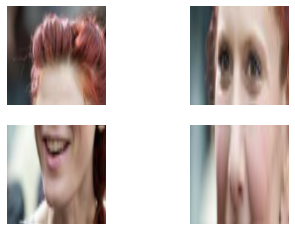

In [ ]:
## Fig 1.x ##
im = im_or[20:]
im = im[0:-20]
im = np.delete(im, slice(0,20), 1)
im = np.delete(im, slice(138,158), 1)
im = resize(im, (pixel_value,pixel_value,3) )

im_hair = im[:40] # Cropping hair
im_hair = resize(im_hair, (pixel_value,pixel_value,3) )
# im_hair = im_hair.flatten()
# test_hair_array[k,:] = im_hair

im_eyes = im[40:60] # Cropping eye
im_eyes = resize(im_eyes, (pixel_value,pixel_value,3) )
# im_eyes = im_eyes.flatten()
# test_eyes_array[k,:] = im_eyes

im_nose = im[60:70] # Cropping nose
im_nose = resize(im_nose, (pixel_value,pixel_value,3) )
# im_nose = im_nose.flatten()
# test_nose_array[k,:] = im_nose

im_jaw = im[70:100] # Cropping jaw
im_jaw = resize(im_jaw, (pixel_value,pixel_value,3) )
# im_jaw = im_jaw.flatten()
# test_jaw_array[k,:] = im_jaw

plt.subplot(2,2,1)
plt.imshow(im_hair/255.)
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(im_eyes/255.)
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(im_nose/255.)
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(im_jaw/255.)
plt.axis("off")